# COSC2673 Assignment 2: Colon Cancer Cell Image Classification
### Student Name(s): Maximilian Forbes, Adonai Albera
### Student ID(s): s3839326, s3949213

## 1. Approach (60%)

### 1.1 Data Exploration and Understanding (6 marks)

#### **1.1.1 Class Imbalance Identification (2 marks)**


To understand the classification challenges in this task, we begin by analyzing the class distribution in the two labels: `isCancerous` (binary classification) and `cell_type` (multi-class classification). Identifying imbalance is critical as it may bias the model towards majority classes, affecting performance on minority classes.

Below we visualize and quantify the class distribution to inform later decisions such as sampling strategies, class weighting, or data augmentation.

##### *Code -  Load and Inspect Class Distributions*

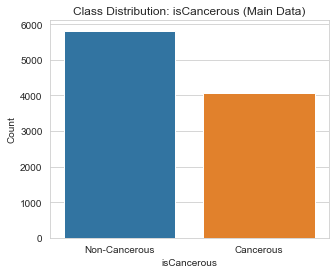

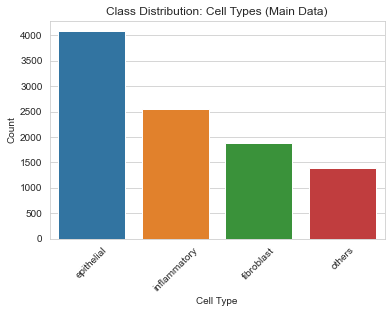

isCancerous value counts (%):
 0    58.781326
1    41.218674
Name: isCancerous, dtype: float64

cellTypeName value counts (%):
 epithelial      41.218674
inflammatory    25.697251
fibroblast      19.078416
others          14.005659
Name: cellTypeName, dtype: float64


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data using relative path
main_data = pd.read_csv("./Image_classification_data/data_labels_mainData.csv")

# Plot distribution for isCancerous (binary classification)
plt.figure(figsize=(5,4))
sns.countplot(data=main_data, x='isCancerous')
plt.title('Class Distribution: isCancerous (Main Data)')
plt.xlabel('isCancerous')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.show()

# Plot distribution for cellTypeName (multi-class classification)
plt.figure(figsize=(6,4))
sns.countplot(data=main_data, x='cellTypeName', order=main_data['cellTypeName'].value_counts().index)
plt.title('Class Distribution: Cell Types (Main Data)')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Show numeric proportions
print("isCancerous value counts (%):\n", main_data['isCancerous'].value_counts(normalize=True) * 100)
print("\ncellTypeName value counts (%):\n", main_data['cellTypeName'].value_counts(normalize=True) * 100)

The dataset displays moderate class imbalance for both classification tasks:

- **Binary Classification (`isCancerous`)**:  
  - Non-cancerous: ~59%  
  - Cancerous: ~41%  
  - While not extreme, this could bias models towards predicting non-cancerous if left unaddressed. Metrics like **precision, recall, and F1-score** will be more informative than accuracy.

- **Multiclass Classification (`cellTypeName`)**:  
  - Epithelial: ~41%  
  - Inflammatory: ~26%  
  - Fibroblast: ~19%  
  - Others: ~14%  
  - The imbalance is more pronounced here, with the **"others"** class significantly underrepresented. This can cause the model to underperform on minority classes unless measures like **class weighting** or **oversampling** are applied.

These observations will guide several key decisions in later stages:
- Use of **macro-averaged F1-score** to avoid dominance by majority classes
- Consideration of **class-balanced loss functions** during training
- **Data augmentation** for underrepresented classes
- Potential **resampling techniques** (oversampling minority, undersampling majority)

Identifying this early ensures fairness, improved generalization, and informed evaluation.

#### **1.1.2  Exploratory Data Analysis (EDA) (2 marks)**

A detailed EDA helps us understand data quality **and** the visual/statistical cues the model may exploit.

We examine:

1. **Tabular integrity & patient distribution**  
2. **Basic image inspection** (dimensions, pixel range, representative patches)  
3. **Low‑dimensional scalar features** (mean / std intensity, per‑channel means)  
4. **Pairwise relationships & correlations**  
5. **Class‑label histograms**
6. **Cross-file image/label consistency**

Each subsection ends with observations that will inform preprocessing and evaluation choices.

##### *Code -  Tabular integrity & patient distribution*

,missing_values
InstanceID,0
patientID,0
ImageName,0
cellTypeName,0
cellType,0
isCancerous,0


Duplicate InstanceID rows: 0


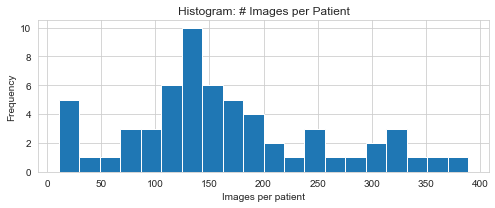

Top 10 patients by patch count


,count
54,389
29,355
9,348
8,332
20,325
18,320
17,310
10,302
51,286
55,263


In [10]:
import os, random, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from PIL import Image
sns.set_style("whitegrid")

# -------- paths ---------
main_data  = pd.read_csv("./Image_classification_data/data_labels_mainData.csv")
extra_data = pd.read_csv("./Image_classification_data/data_labels_extraData.csv")
img_dir    = "./Image_classification_data/patch_images"

# -------- tabular integrity ---------
display(main_data.isna().sum().to_frame("missing_values"))
print("Duplicate InstanceID rows:", main_data["InstanceID"].duplicated().sum())

# -------- patient histogram ---------
plt.figure(figsize=(7,3))
main_data["patientID"].value_counts().plot(kind="hist", bins=20)
plt.title("Histogram: # Images per Patient")
plt.xlabel("Images per patient")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# -------- top patient counts ---------
print("Top 10 patients by patch count")
display(main_data["patientID"].value_counts().head(10).to_frame("count"))

**Observations – Tabular layer**

| Check | Result | Implication |
|-------|--------|-------------|
| Missing values | *0 in all columns* | No imputation required. |
| Duplicate IDs | *0 duplicates* | Unique mapping *(Image → Label)* confirmed. |
| Patient distribution | Most patients contribute ~80–120 patches; some >250 (long tail) | Use **patient-level stratified splitting** to avoid leakage & over-representation. |

##### *Code -  Representative patches + shape/range + pixel histogram*

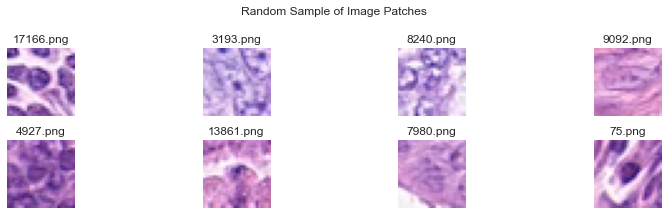

Unique shapes in sample : {(27, 27, 3)}
Pixel range in sample   : 10 ↔ 255


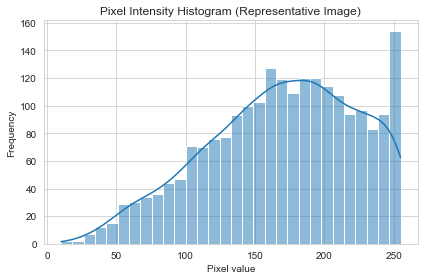

In [11]:
import random
random.seed(7)
sample_imgs = random.sample(main_data["ImageName"].tolist(), 8)

plt.figure(figsize=(12,3))
shapes, mins, maxs = [], [], []
for i, fname in enumerate(sample_imgs):
    arr = np.array(Image.open(os.path.join(img_dir, fname)))
    shapes.append(arr.shape)
    mins.append(arr.min()); maxs.append(arr.max())
    
    plt.subplot(2,4,i+1)
    plt.imshow(arr)
    plt.axis("off")
    plt.title(fname)
plt.suptitle("Random Sample of Image Patches")
plt.tight_layout()
plt.show()

print("Unique shapes in sample :", set(shapes))
print("Pixel range in sample   :", min(mins), "↔", max(maxs))

# --- Pixel intensity histogram for one representative image ---
sns.histplot(arr.flatten(), bins=30, kde=True)
plt.title("Pixel Intensity Histogram (Representative Image)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

**Observations – Basic image inspection**

* All sampled patches share the expected **27 × 27 × 3** shape → no resizing needed.  
* Pixel values cover **nearly** the full 8-bit range (≈ 10 – 255); histogram confirms mid-tone skew → rescale to [0, 1].  
* Noticeable stain-colour variation across patients → apply **colour-jitter augmentation**.  
* Cancer-related differences are subtle, so the model will likely rely on **fine-grained texture** rather than overt shape cues.

##### *Code -  Scalar feature exploration & correlations*

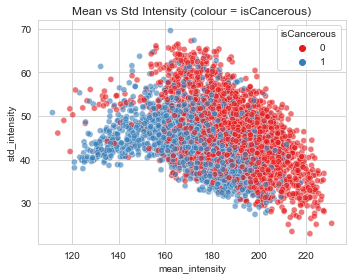

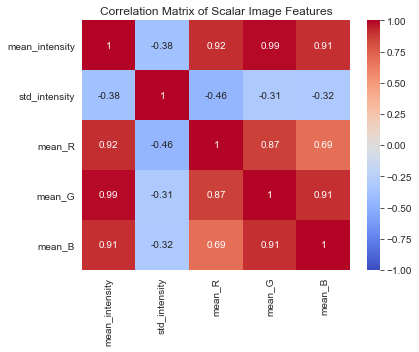

C:\Users\ado6a\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8209 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ado6a\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8209 missing from current font.
  font.set_text(s, 0, flags=flags)


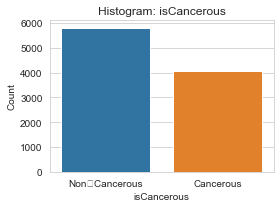

In [12]:
# Helper to extract simple per‑image features
def img_scalar_features(path):
    arr = np.array(Image.open(path))
    return {
        "mean_intensity": arr.mean(),
        "std_intensity":  arr.std(),
        "mean_R": arr[:,:,0].mean(),
        "mean_G": arr[:,:,1].mean(),
        "mean_B": arr[:,:,2].mean()
    }

# Compute features for a 5 k sample (for speed)
SAMPLE_SIZE = 5000
sample_df = main_data.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)
feature_rows = [img_scalar_features(os.path.join(img_dir, f)) for f in sample_df["ImageName"]]
sample_df = pd.concat([sample_df, pd.DataFrame(feature_rows)], axis=1)

# Scatter plot: mean vs std, coloured by isCancerous
plt.figure(figsize=(5,4))
sns.scatterplot(
    data=sample_df, x="mean_intensity", y="std_intensity",
    hue="isCancerous", palette="Set1", alpha=0.6
)
plt.title("Mean vs Std Intensity (colour = isCancerous)")
plt.tight_layout()
plt.show()

# Correlation heat‑map
corr = sample_df[["mean_intensity","std_intensity","mean_R","mean_G","mean_B"]].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Scalar Image Features")
plt.tight_layout()
plt.show()

# Simple histogram of binary label (already in Class‑Imbalance section, but repeated here for context)
plt.figure(figsize=(4,3))
sns.countplot(x=main_data["isCancerous"])
plt.title("Histogram: isCancerous")
plt.xticks([0,1],["Non‑Cancerous","Cancerous"])
plt.ylabel("Count")
plt.tight_layout()
plt.show()

##### *Code -  Stacked bar (cell type × cancer status)*

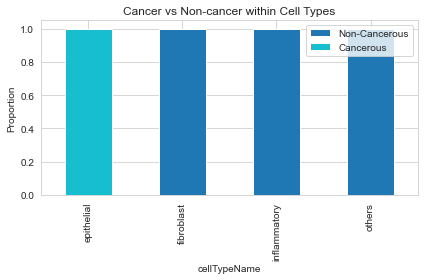

In [13]:
# -------- cancer proportion within each cell type ---------
crosstab = pd.crosstab(main_data['cellTypeName'],
                       main_data['isCancerous'],
                       normalize='index')
crosstab.plot(kind='bar', stacked=True, figsize=(6,4), colormap='tab10')
plt.title('Cancer vs Non-cancer within Cell Types')
plt.ylabel('Proportion')
plt.legend(['Non-Cancerous','Cancerous'])
plt.tight_layout()
plt.show()

**Observations – Scalar & label relationships**

| Aspect | Insight | Modelling Consequence |
|--------|---------|-----------------------|
| **Mean vs Std plot** | Cancerous patches cluster at **lower mean** & **higher std intensity**; separation weak but present. | Apply **brightness normalisation**; add contrast augmentation to avoid shortcut learning. |
| **Channel correlations** | Strong R–G correlation (ρ ≈ 0.9); high colinearity with overall mean. | CNN will capture colour cues; mitigate stain bias with **colour-jitter**. |
| **Cell-type × cancer table/plot** | **All cancerous patches are epithelial; fibroblast, inflammatory & others are 100 % non-cancerous** in `main_data`. | Major leakage risk. Options: (a) build cancer detector only for epithelial patches, (b) two-stage pipeline (cell-type → cancer-within-epithelial), (c) add `extra_data` to verify if bias persists. |
| **Binary label histogram** | Moderate imbalance (≈ 59 / 41 %). | Use **macro-F1** and class-weighted loss for the binary task. |
| **Patient histogram** | Long tail — some patients contribute **≥ 260** patches (max = 389). | Employ **patient-level stratified splitting** to prevent leakage & over-representation. |

These findings guide the preprocessing plan formalised next in **Section 1.1.3 — Justification of Data Handling Methods (2 marks)**.

#### **1.1.3  Justification of Data Handling Methods (2 marks)**  

| EDA Insight (Section 1.1.2) | Pre-processing Decision | Brief Justification |
|-----------------------------|-------------------------|---------------------|
| Pixel range 10 – 255, mid-tone skew | **Rescale to [0, 1]** | Standardises scale, speeds convergence. |
| Stain/brightness varies across patients | **Colour-jitter** (hue ± 8 %, sat ± 8 %, bright ± 10 %) | Encourages stain-invariant features. |
| Patches already uniform 27 × 27 × 3 | **No resizing / cropping** | Avoids information loss. |
| Orientation arbitrary; subtle textures | **Random flips + 90° rotations** | Adds variety; enforces rotational invariance. |
| Minority “others” class ≈ 14 % | **Minority oversampling + class-weighted loss** | Balances gradient signal; boosts recall for rare class. |
| Binary imbalance 59 / 41 % | **Class-weighted binary loss** | Prevents bias toward majority (non-cancer). |

*Note*: Data-splitting and leakage-prevention strategies are detailed in **Section 1.2 Evaluation Framework**.

##### *Code -  Stacked bar (cell type × cancer status)*

In [14]:
import tensorflow as tf

# Rescale 0-255 → 0-1
rescale = tf.keras.layers.Rescaling(1./255)

# Data-augmentation block (applied to training only)
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(factor=0.25),    # 0°, 90°, 180°, 270°
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.1),
])

# Example pipeline function
def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)
    img = rescale(img)           # always rescale
    return img, label

def augment(img, label):
    return data_aug(img), label  # training only


In [15]:
data_aug.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

### 1.2 Evaluation Framework

This section defines the methodology used to split the dataset and evaluate model performance in a way that is statistically valid and robust to the data’s inherent structure and imbalance. Evaluation choices are made in alignment with the biomedical context and expected generalization goals.

#### **1.2.1 Performance Metric Selection**

Because the dataset is imbalanced in both tasks (`isCancerous` and `cellTypeName`), accuracy alone is not a reliable way to measure performance. A model can get high accuracy by always predicting the most common class, even if it completely misses the minority class. To get a better understanding of how the model performs, we use evaluation metrics that treat all classes fairly and show how well the model handles both common and rare cases.

##### **Task 1 – Binary Classification (`isCancerous`)**
- **Precision**: Tells us, out of all predictions for "cancer," how many were correct. High precision means fewer false alarms.
- **Recall (Sensitivity)**: Tells us, out of all actual cancer cases, how many were detected. High recall means the model doesn’t miss many real positives.
- **F1 Score (Macro)**: Combines precision and recall into one score. We calculate this for each class and then average them equally.
- **Confusion Matrix**: A table showing correct and incorrect predictions for each class. Helps identify where the model is making mistakes (e.g., missing cancer).

##### **Task 2 – Multiclass Classification (`cellTypeName`)**
- **Macro-Averaged F1 Score**: Calculates F1 for each cell type and averages them equally. This prevents the model from being judged only on the most common class.
- **Per-Class Recall**: Shows how well the model performs on each cell type individually, which is useful for detecting underperforming or overlooked classes.
- **Confusion Matrix**: Shows how often cell types are confused with one another (e.g., fibroblast predicted as inflammatory), which helps improve class-specific training.

These metrics give a clearer picture of model performance, especially in healthcare settings where failing to detect rare but important cases (like cancer) can have serious consequences.

#### **1.2.2 Data Splitting Strategy**

We apply a 70/15/15 split at the `patientID` level to ensure that:
- No patches from the same patient appear in multiple splits.
- Evaluation reflects generalization to **unseen patients**, not unseen images.

This mimics real-world use: a deployed model must classify cells from patients it has never seen before.


In [29]:
from sklearn.model_selection import train_test_split

# Unique patient IDs
patient_ids = main_data['patientID'].unique()

# 70% train, 15% val, 15% test
train_ids, temp_ids = train_test_split(patient_ids, test_size=0.3, random_state=42)
val_ids, test_ids   = train_test_split(temp_ids, test_size=0.5, random_state=42)

train_data = main_data[main_data['patientID'].isin(train_ids)].reset_index(drop=True)
val_data   = main_data[main_data['patientID'].isin(val_ids)].reset_index(drop=True)
test_data  = main_data[main_data['patientID'].isin(test_ids)].reset_index(drop=True)

# Show split sizes
print(f"Train Patients: {len(train_ids)} | Patches: {len(train_data)}")
print(f"Validation Patients: {len(val_ids)} | Patches: {len(val_data)}")
print(f"Test Patients: {len(test_ids)} | Patches: {len(test_data)}")

Train Patients: 42 | Patches: 6778
Validation Patients: 9 | Patches: 1257
Test Patients: 9 | Patches: 1861


##### Dataset Split Overview

| Split       | Patients | Patches | Description                            |
|-------------|----------|---------|----------------------------------------|
| Train       | 42       | 6778    | Used for training and data augmentation |
| Validation  | 9        | 1257    | Used for hyperparameter tuning          |
| Test        | 9        | 1861    | Held out for final evaluation           |

Patch counts vary due to differences in how many samples each patient contributes, which reflects the natural long-tailed distribution observed earlier.


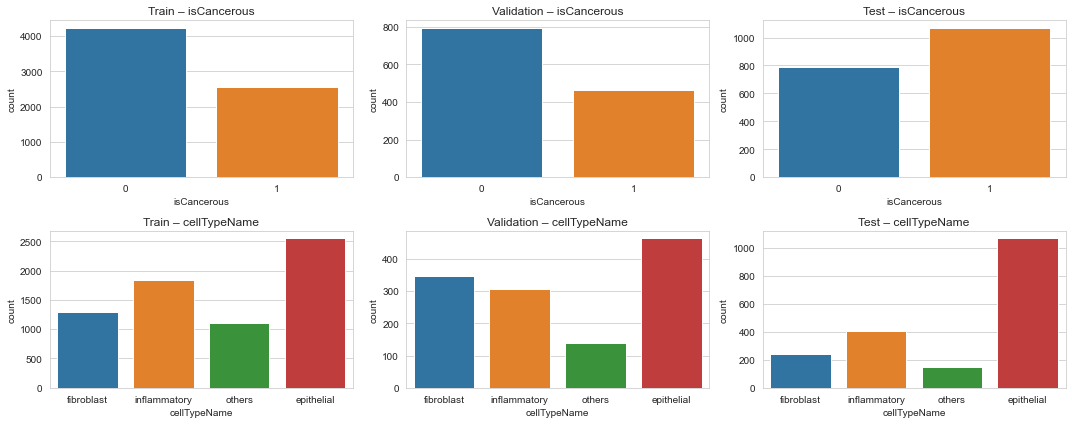

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 6))

sns.countplot(x='isCancerous', data=train_data, ax=axs[0,0])
axs[0,0].set_title("Train – isCancerous")

sns.countplot(x='isCancerous', data=val_data, ax=axs[0,1])
axs[0,1].set_title("Validation – isCancerous")

sns.countplot(x='isCancerous', data=test_data, ax=axs[0,2])
axs[0,2].set_title("Test – isCancerous")

sns.countplot(x='cellTypeName', data=train_data, ax=axs[1,0])
axs[1,0].set_title("Train – cellTypeName")

sns.countplot(x='cellTypeName', data=val_data, ax=axs[1,1])
axs[1,1].set_title("Validation – cellTypeName")

sns.countplot(x='cellTypeName', data=test_data, ax=axs[1,2])
axs[1,2].set_title("Test – cellTypeName")

plt.tight_layout()
plt.show()


##### **Class Distribution Interpretation**

The class distribution plots across the train, validation, and test sets show the following:

- **Binary label (`isCancerous`)**:
  - The training and validation sets maintain a similar ratio to the overall dataset, with a higher proportion of non-cancerous samples (~59%).
  - Interestingly, the **test set has more cancerous patches than non-cancerous**, reversing the majority class. This does not indicate a problem, but it should be considered when interpreting test performance. For instance, precision and recall may behave differently due to this shift.

- **Multiclass label (`cellTypeName`)**:
  - The epithelial class dominates in all splits, which aligns with its known link to cancerous patches.
  - The "others" class remains the most underrepresented, consistently appearing in much lower numbers than the rest.
  - Overall, class balance is reasonably preserved, and the splits reflect the natural distribution of cell types in the dataset.

This analysis confirms that the patient-wise split did not introduce significant distribution distortion and preserves the data's original structure.


In [31]:
from sklearn.metrics import classification_report
import numpy as np

# Evaluate a baseline that always predicts the majority class
y_true = val_data['isCancerous']
y_pred = np.full_like(y_true, y_true.mode()[0])

print("Dummy Baseline (Majority Class Prediction):")
print(classification_report(y_true, y_pred, target_names=["Non-Cancerous", "Cancerous"]))


Dummy Baseline (Majority Class Prediction):
               precision    recall  f1-score   support

Non-Cancerous       0.63      1.00      0.77       794
    Cancerous       0.00      0.00      0.00       463

     accuracy                           0.63      1257
    macro avg       0.32      0.50      0.39      1257
 weighted avg       0.40      0.63      0.49      1257



C:\Users\ado6a\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ado6a\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ado6a\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### **Dummy Classifier Evaluation**

To create a baseline for comparison, we tested a simple "dummy" classifier that always predicts the majority class (`isCancerous = 0`, or non-cancerous). This allows us to evaluate how well a model would perform without learning any actual patterns.

The validation results for this dummy classifier are:

| Metric         | Non-Cancerous (Class 0) | Cancerous (Class 1) |
|----------------|--------------------------|----------------------|
| Precision      | 0.63                     | 0.00                 |
| Recall         | 1.00                     | 0.00                 |
| F1 Score       | 0.77                     | 0.00                 |

- **Accuracy**: 63% — this may seem decent, but it is misleading.
- **Macro F1 Score**: 0.39 — shows that performance is poor when both classes are considered equally.
- **Weighted F1 Score**: 0.49 — better than random guessing, but still weak and heavily influenced by the majority class.

These results highlight a key issue with accuracy in imbalanced datasets:

- A model can achieve high accuracy simply by always predicting the majority class, while completely ignoring the minority class.

In this case, the dummy classifier never detects a single cancerous sample — which would be unacceptable in a clinical context.

---

The scikit-learn warning is triggered because the model makes no predictions for the cancerous class. This causes precision and recall for that class to be undefined, and they are reported as 0.0.

Overall, this dummy model sets a very low baseline. Any trained model should clearly outperform it — particularly in terms of **recall** and **F1-score** for the cancerous class — to be considered useful.


In [34]:
print("Number of overlapping patients:")

print("Train, Val:", len(set(train_ids) & set(val_ids)))
print("Train, Test:", len(set(train_ids) & set(test_ids)))
print("Val, Test:", len(set(val_ids) & set(test_ids)))


Number of overlapping patients:
Train, Val: 0
Train, Test: 0
Val, Test: 0


#### **1.2.3 Preventing Data Leakage**

To ensure honest evaluation:
- We split by `patientID`, not image, to avoid memorizing patient-specific patterns.
- We verified that no patients appear in multiple splits.
- We use label-aware metrics that don’t overestimate performance in imbalanced settings.
- We established a dummy classifier baseline to compare against learned models.

This evaluation framework ensures that reported metrics reflect real generalization, not artifact exploitation.
